In [ ]:
import numpy as np
import pandas as pd
# for visualization
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from sklearn.preprocessing import StandardScaler # for scaling the features.
# Association rules
from mlxtend.frequent_patterns import apriori, association_rules



## Functions

In [ ]:
#### Functions
# For Standardize
def standardize_features(df, feature_cols):
    """
    Normalize the data.
    """
    scaler = StandardScaler() # normalization setting
    X_scaled = scaler.fit_transform(df[feature_cols].values)
    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)
    return df_scaled, scaler

# For Association Rule
def discretize_for_association(df, bins = 3):
    """
    Discretize continuous variables into low/medium/high labels
    for association rules. 
    strategy: "uniform" uses cut with equal-width bins.
    Returns a one-hot encoded boolean DataFrame.
    """
    labels = ["low", "medium", "high"][:bins]   # 避免 bins !=3 時報錯
    disc = {}

    for col in df.columns:
        series = df[col]
        try:
            cats = pd.cut(series, bins=bins, labels=labels)
        except ValueError:
            # Fallback: if too few unique values, treat as is
            nbins = min(bins, max(2, series.nunique()))
            fallback_labels = labels[:nbins]
            cats = pd.cut(series, bins=nbins, labels=fallback_labels, duplicates="drop")
        disc[col] = cats.astype(str)

    disc_df = pd.DataFrame(disc, index=df.index)

    # One-hot encoding for mlxtend
    ohe_parts = []
    for col in disc_df.columns:
        dummies = pd.get_dummies(disc_df[col], prefix=col, dtype=bool)
        ohe_parts.append(dummies)

    return pd.concat(ohe_parts, axis=1)


def run_association_rules(ohe_df, min_support = 0.1,
                          min_confidence = 0.5, min_lift = 1.0):
    freq = apriori(ohe_df.astype(bool), min_support=min_support, use_colnames=True)
    if freq.empty:
        return pd.DataFrame()
    rules = association_rules(freq, metric="confidence", min_threshold=min_confidence)
    rules = rules[rules['antecedents'].apply(lambda x: len(x) <= 1)]
    rules = rules[rules['consequents'].apply(lambda x: len(x) == 1)]
    if "lift" in rules.columns:
        rules = rules[rules["lift"] >= min_lift]
    # Sort by confidence then lift
    rules = rules.sort_values(["confidence", "lift"], ascending=False)
    return rules.reset_index(drop=True)

## Main

In [53]:
output = "/Users/ching-yalin/Desktop/TIGP/2025_Fall/Biological Computing (C1)/2025-10-27_Introduction to Data Mining (Dr. Henry Horng-Shing Lu)/outputs/"
#### Data loading
wine_df = pd.read_csv("/Users/ching-yalin/Desktop/TIGP/2025_Fall/Biological Computing (C1)/2025-10-27_Introduction to Data Mining (Dr. Henry Horng-Shing Lu)/wine+quality/winequality-red.csv", sep = ';')
#### Standardization
feature_col = [col for col in wine_df if col != 'quality'] # quality is final predicted results
scaled_df, scaler = standardize_features(wine_df, feature_col)
scaled_df.head()
# Note: the scaled data only for PCA and clustering
quality_threshold = 6 # The wine_quality threshold for good/bad label.


### Association Rules

In [74]:
#### Association Rules
df_for_assoc = wine_df.copy()
df_for_assoc['quality_bin'] = np.where(df_for_assoc['quality'] >= quality_threshold,'good','bad')
# Create one-hot encoding table for quality
ohe_quality = pd.get_dummies(df_for_assoc['quality_bin'],prefix='quality',dtype=bool)
# Create one-hot encoding table for other features
ohe_features = discretize_for_association(df_for_assoc[feature_col],bins=3)
# Create one-hot encoding table for association rule analysis
ohe = pd.concat([ohe_features, ohe_quality], axis=1)
rules_all = run_association_rules(ohe, min_support=0.08, min_confidence=0.5, min_lift=1.0)
# Remain the quality association results from all rules
quality_rules = rules_all[rules_all['consequents'].apply(lambda s: ('quality_good' in s) or ('quality_bad' in s))]
# Prevent quality appear in antecedents because we only want to see feature -> quality
quality_rules = quality_rules[~quality_rules['antecedents'].apply(lambda s: any(str(item).startswith('quality_') for item in s))]
quality_rules = quality_rules.reset_index(drop=True)
quality_rules.to_csv( output + "assoc_rules.csv", index=False)
quality_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(alcohol_medium),(quality_good),0.349593,0.534709,0.275172,0.787120,1.472052,1.0,0.088241,2.185694,0.493040,0.451745,0.542479,0.650870
1,(density_low),(quality_good),0.106942,0.534709,0.083177,0.777778,1.454581,1.0,0.025994,2.093809,0.349940,0.148936,0.522401,0.466667
2,(citric acid_medium),(quality_good),0.347092,0.534709,0.227017,0.654054,1.223196,1.0,0.041424,1.344981,0.279472,0.346705,0.256495,0.539308
3,(volatile acidity_medium),(quality_bad),0.308318,0.465291,0.200125,0.649087,1.395014,1.0,0.056668,1.523767,0.409381,0.348964,0.343732,0.539597
4,(alcohol_low),(quality_bad),0.616010,0.465291,0.385241,0.625381,1.344064,1.0,0.098617,1.427340,0.666653,0.553459,0.299396,0.726669


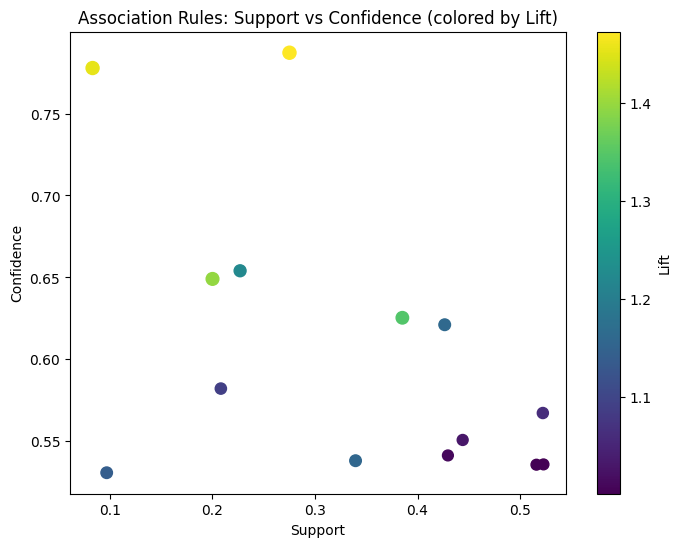

In [75]:
# Support-Confidnece-Lift Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(quality_rules['support'], quality_rules['confidence'],
            c=quality_rules['lift'], cmap='viridis', s=quality_rules['lift']*60)

plt.colorbar(label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (colored by Lift)')
plt.show()

In [ ]:
## Top 5 rules
quality_rules.sort_values("lift", ascending=False).head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(alcohol_medium),(quality_good),0.349593,0.534709,0.275172,0.787120,1.472052,1.0,0.088241,2.185694,0.493040,0.451745,0.542479,0.650870
1,(density_low),(quality_good),0.106942,0.534709,0.083177,0.777778,1.454581,1.0,0.025994,2.093809,0.349940,0.148936,0.522401,0.466667
3,(volatile acidity_medium),(quality_bad),0.308318,0.465291,0.200125,0.649087,1.395014,1.0,0.056668,1.523767,0.409381,0.348964,0.343732,0.539597
4,(alcohol_low),(quality_bad),0.616010,0.465291,0.385241,0.625381,1.344064,1.0,0.098617,1.427340,0.666653,0.553459,0.299396,0.726669
2,(citric acid_medium),(quality_good),0.347092,0.534709,0.227017,0.654054,1.223196,1.0,0.041424,1.344981,0.279472,0.346705,0.256495,0.539308


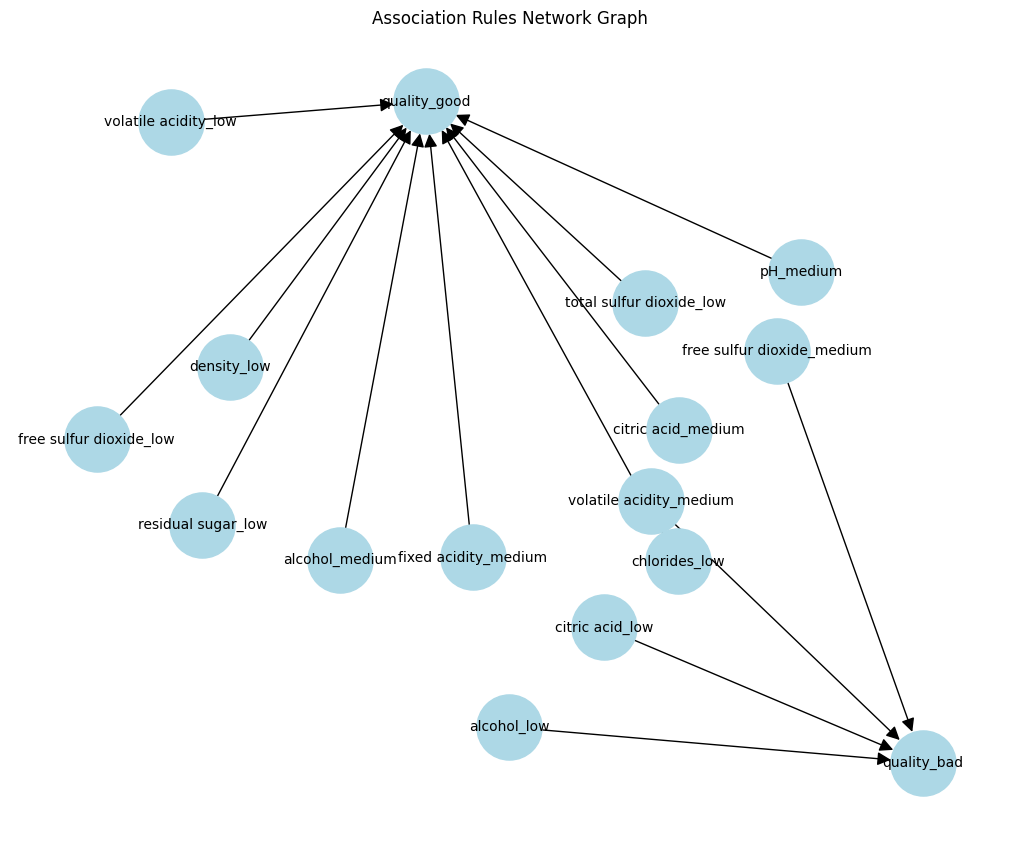

In [ ]:
# Graph network
G = nx.DiGraph()

for _, row in quality_rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            G.add_edge(a, c, weight=row['lift'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.9)
nx.draw(G, pos, with_labels=True, node_size=2200,
        node_color='lightblue', arrowsize=20, font_size=10)
plt.title("Association Rules Network Graph")
plt.show()

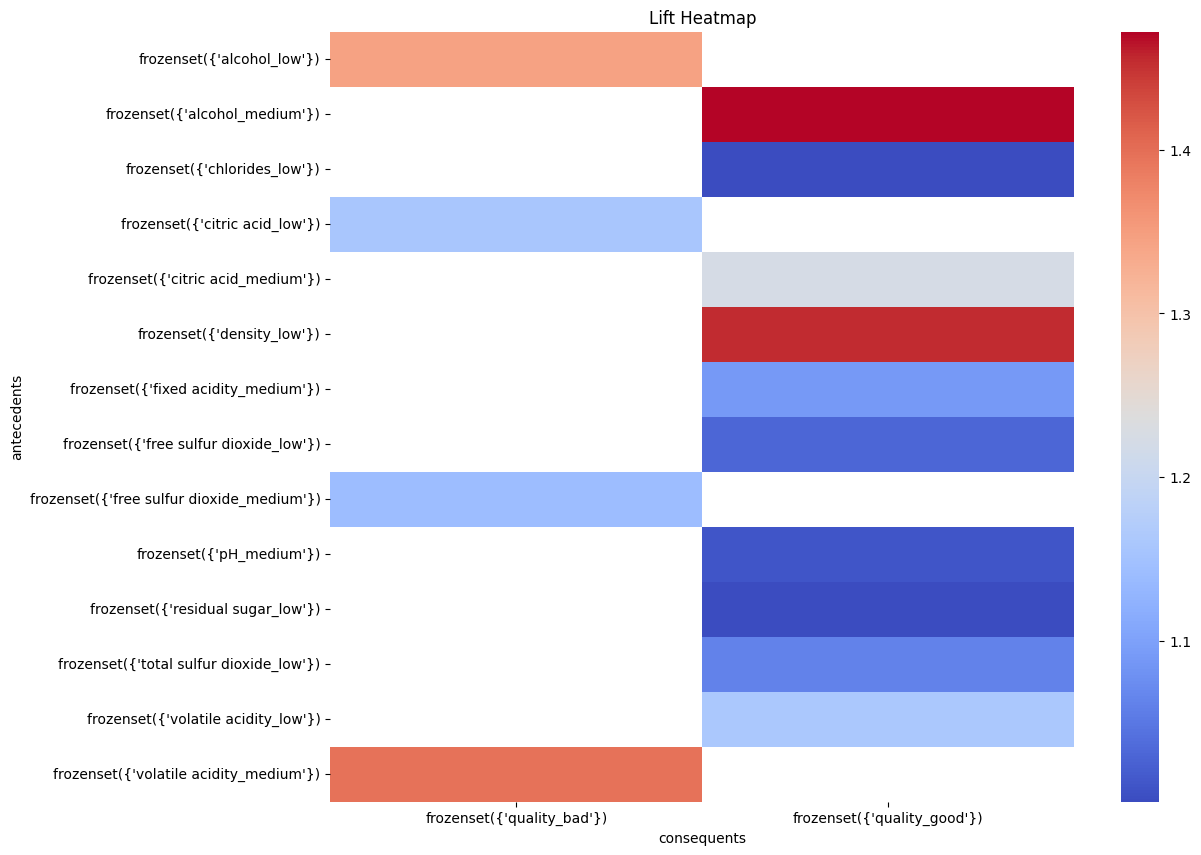

In [ ]:
# Lift Heatmap
pivot = quality_rules.pivot_table(
    values='lift',
    index=quality_rules['antecedents'].astype(str),
    columns=quality_rules['consequents'].astype(str)
)

plt.figure(figsize=(12, 10))
sns.heatmap(pivot, annot=False, cmap='coolwarm')
plt.title("Lift Heatmap")
plt.show()

### Decision tree

In [ ]:
def run_decision_tree(df: pd.DataFrame, feature_cols: list, target_col: str,
                      test_size: float = 0.2, random_state: int = 42,
                      max_depth: int = None) -> Tuple[DecisionTreeClassifier, dict]:
    X = df[feature_cols].values
    y = df[target_col].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    clf = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results = {
        "classification_report": report,
        "confusion_matrix": cm,
        "feature_importances": clf.feature_importances_,
        "test_size": test_size,
    }
    return clf, results

#### Prepare classification target for Decision Tree
quality_threshold = 0.6 # quality >= 0.6: good, quality < 0.6: bad
df_cls = wine_df.copy()
df_cls["high_quality"] = (df_cls["quality"] >= quality_threshold).astype(int) # Turn Ture to 1, False to 0
target_col = "high_quality"

#### Decision tree
clf, dt_results = run_decision_tree(df_cls, feature_cols, target_col,
                                        test_size=args.test_size,
                                        random_state=args.random_state,
                                        max_depth=args.max_depth)
# Save report
rep = dt_results["classification_report"]
cm = dt_results["confusion_matrix"]
fi = dt_results["feature_importances"]

with open(os.path.join(outdir, "decision_tree_report.txt"), "w", encoding="utf-8") as f:
    f.write("=== Classification Report ===\\n")
    f.write(pd.DataFrame(rep).T.round(3).to_string())
    f.write("\\n\\n=== Confusion Matrix ===\\n")
    f.write(pd.DataFrame(cm).to_string())
    f.write("\\n\\n=== Feature Importances ===\\n")
    f.write(pd.Series(fi, index=feature_cols).sort_values(ascending=False).round(4).to_string())

# Optional: save a quick PNG plot of the tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=feature_cols, class_names=["low", "high"], filled=True, max_depth=3)
plt.tight_layout()
plt.savefig(os.path.join(outdir, "decision_tree.png"), dpi=150)
plt.close()

### Clustering (Kmeans)

In [ ]:
def run_kmeans(df_scaled: pd.DataFrame, k: int = 3, random_state: int = 42) -> Tuple[KMeans, pd.Series, float]:
    km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
    labels = km.fit_predict(df_scaled.values)
    # For silhouette, need at least 2 clusters and < n samples
    sil = np.nan
    if k > 1 and len(df_scaled) > k:
        try:
            sil = silhouette_score(df_scaled.values, labels)
        except Exception:
            sil = np.nan
    return km, pd.Series(labels, index=df_scaled.index, name="cluster"), sil


km, labels, silhouette = run_kmeans(scaled_df, k=args.k, random_state=args.random_state)
kmeans_summary = df.assign(cluster=labels.values).groupby("cluster") \
                    .agg({"quality": ["count", "mean", "std"]}).round(3)
kmeans_summary.columns = ["_".join(col) for col in kmeans_summary.columns]
kmeans_summary["silhouette_overall"] = silhouette
kmeans_summary.to_csv(os.path.join(outdir, "kmeans_summary.csv"))
log(f"KMeans finished. Silhouette score: {silhouette}", logfile)



# By cluster
plt.figure(figsize=(6, 5))
for cl in sorted(labels.unique()):
    mask = labels == cl
    plt.scatter(pc1[mask], pc2[mask], s=10, alpha=0.7, label=f"cluster {cl}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter colored by KMeans cluster")
plt.legend(fontsize=8, loc="best")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "pca_scatter_by_cluster.png"), dpi=150)
plt.close()


### PCA

In [ ]:
def run_pca(df_scaled: pd.DataFrame, n_components: int = 2, outdir: str = "outputs"):
    pca = PCA(n_components=n_components, random_state=42)
    Xp = pca.fit_transform(df_scaled.values)
    explained = pca.explained_variance_ratio_

    # Scatter plot (PC1 vs PC2)
    plt.figure(figsize=(6, 5))
    plt.scatter(Xp[:, 0], Xp[:, 1], s=10, alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Scatter (PC1 vs PC2)")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "pca_scatter.png"), dpi=150)
    plt.close()

    # Scree plot
    plt.figure(figsize=(6, 4))
    xs = np.arange(1, len(explained) + 1)
    plt.plot(xs, explained, marker="o")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("PCA Scree Plot")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "pca_scree.png"), dpi=150)
    plt.close()

    comp_df = pd.DataFrame({
        "component": [f"PC{i+1}" for i in range(len(explained))],
        "explained_variance_ratio": explained
    })
    loadings = pd.DataFrame(
        pca.components_.T,
        index=df_scaled.columns,
        columns=[f"PC{i+1}" for i in range(len(explained))]
    )
    return pca, Xp, comp_df, loadings


# 8) PCA (on standardized features)
pca, Xp, comp_df, loadings = run_pca(scaled_df, n_components=min(5, scaled_df.shape[1]), outdir=outdir)
comp_df.to_csv(os.path.join(outdir, "pca_variance.csv"), index=False)
loadings.to_csv(os.path.join(outdir, "pca_loadings.csv"))

# 9) Save a PCA scatter colored by quality (binned) and by cluster (two figs)
#    (Note: keep plots simple with matplotlib only)
pc1, pc2 = Xp[:, 0], Xp[:, 1]

# By quality bins
qual_bins = pd.qcut(df["quality"], q=min(4, df["quality"].nunique()), duplicates="drop")
plt.figure(figsize=(6, 5))
for cat in qual_bins.unique():
    mask = qual_bins == cat
    plt.scatter(pc1[mask], pc2[mask], s=10, alpha=0.7, label=str(cat))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter colored by quality bins")
plt.legend(fontsize=8, loc="best")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "pca_scatter_by_quality.png"), dpi=150)
plt.close()